In [37]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import warnings
import scikitplot
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
car = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
car.columns = ['buying', 'maint','door','person','lug_boot','safety','cls']

## Data Transformation - Categorical and Numerical

In [3]:
# Categorical Data
cars_new = pd.get_dummies(car.iloc[:,0:6])
cars_new['cls'] = car['cls']

In [4]:
# Numerical Data
cars = car.loc[:,:]
buying_dict = {'vhigh':4,'high':3,'med':2,'low':1}
maint_dict = {'vhigh':4,'high':3,'med':2,'low':1}
door_dict = {'2':2,'3':3,'4':4,'5more':5}
person_dict = {'2':2,'4':4,'more':5}
lug_dict = {'small':1,'med':2,'big':3}
safety_dict = {'low':1,'med':2,'high':3}
#['buying', 'maint','door','person','lug_boot','safety','cls']
cars['buying'] = car['buying'].map(buying_dict)
cars['maint'] = car['maint'].map(maint_dict)
cars['door'] = car['door'].map(door_dict)
cars['person'] = car['person'].map(person_dict)
cars['lug_boot'] = car['lug_boot'].map(lug_dict)
cars['safety'] = car['safety'].map(safety_dict)
cars['cls'] = car['cls']

In [5]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
#Creating arrays to store the values of all models to compare different models
accuracy_all_models = []
cross_val_score_all_models = []
precision_all = []
recall_all = []
f_measure_all = []
std_all_models = []

## Decision Tree

### Categorical

In [13]:
# Fetching predictors and classifier and splitting into test and train
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

In [14]:
# Nested Cross Validation to be able to comapre across models
NUM_TRIALS = 10
param = {'max_depth':np.arange(1,30,2),'criterion':['entropy','gini']}
#non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

dtc = DecisionTreeClassifier()
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=dtc, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train, y_train)
    #non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 96.77% / 0.51%


### Numerical

In [29]:
# Fetching predictors and classifier and splitting into test and train
X = cars.loc[:,['buying','maint','door','person','lug_boot','safety']]
y = cars.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [30]:
# Nested Cross Validation to be able to compare across models
NUM_TRIALS = 10
param = {'max_depth':np.arange(1,30,2), 'criterion':['entropy','gini']}
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

dtc = DecisionTreeClassifier()
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=dtc, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train_std, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train_std, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 97.51% / 0.50%


# Naive Bayes

### Categorical

In [16]:
# Fetching predictors and classifier and splitting into test and train
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

In [17]:
#NESTED Cross Validation
NUM_TRIALS = 10
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

nb = BernoulliNB()
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator = nb, param_grid = {}, cv=inner_cv)
    clf_2.fit(X_train, y_train)
    #non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 85.72% / 0.52%


### Numerical

In [18]:
# Fetching predictors and classifier and splitting into test and train
X = cars.loc[:,['buying','maint','door','person','lug_boot','safety']]
y = cars.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [19]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

nb = GaussianNB()
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator = nb, param_grid = {}, cv=inner_cv)
    clf_2.fit(X_train_std, y_train)
    #non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train_std, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 76.02% / 0.31%


# k-Nearest Neighbor

### Categorical

In [20]:
# Fetching predictors and classifier and splitting into test and train
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

In [21]:
#Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = {'n_neighbors':list(range(1,15)), 'weights': ["uniform", "distance"]}
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

knn = KNeighborsClassifier()

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=knn, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 90.41% / 0.72%


### Numerical

In [22]:
# Fetching predictors and classifier and splitting into test and train
X = cars.loc[:,['buying','maint','door','person','lug_boot','safety']]
y = cars.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [23]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = {'n_neighbors':list(range(1,15)), 'weights': ["uniform", "distance"]}
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

knn = KNeighborsClassifier()
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=knn, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train_std, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train_std, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(),nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 95.94% / 0.51%


# Logistic Regression (Multiclass)

### Categorical

In [24]:
# Fetching predictors and classifier and splitting into test and train
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

In [25]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = {"C": [0.1, 1, 10, 100], "penalty" : ['l1','l2']}
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

lreg = LogisticRegression(solver = 'saga', multi_class = 'multinomial')
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=lreg, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(),nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_score.std())

The final accuracy from nested cross validation is 93.78% / 0.31%


### Numerical

In [26]:
# Fetching predictors and classifier and splitting into test and train
X = cars.loc[:,['buying','maint','door','person','lug_boot','safety']]
y = cars.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [27]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = {"C": [0.1, 1, 10, 100], "penalty" : ['l1','l2']}
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

lreg = LogisticRegression(solver = 'saga', multi_class = 'multinomial')
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=lreg, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train_std, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train_std, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(),nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 84.78% / 0.46%


# Support Vector Machine

### Categorical

In [7]:
# Fetching predictors and classifier and splitting into test and train
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

In [8]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-5, 1e-7],
                     'C': [.001, .01, 1, 5, 10, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [.001, .01, 1, 10, 100, 1000]},
                    {'kernel':['poly'], 'C':[.001, .01, 1, 10, 100, 1000], 'degree':[1,3,5]}] 

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

sup_vec = SVC(probability = True)
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=sup_vec, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(),nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 99.34% / 0.32%


### Numerical

In [9]:
# Fetching predictors and classifier and splitting into test and train
X = cars.loc[:,['buying','maint','door','person','lug_boot','safety']]
y = cars.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [10]:
# Nested Cross Validation to compare accuracies across models
NUM_TRIALS = 10
param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-5, 1e-7],
                     'C': [.001, .01, 1, 5, 10, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [.001, .01, 1, 10, 100, 1000]},
                    {'kernel':['poly'], 'C':[.001, .01, 1, 10, 100, 1000], 'degree':[1,3,5]}] 
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

sup_vec = SVC(probability = True)
# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_2 = GridSearchCV(estimator=sup_vec, param_grid=param, cv=inner_cv)
    clf_2.fit(X_train_std, y_train)
    non_nested_scores[i] = clf_2.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf_2, X=X_train_std, y=y_train, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(),nested_scores.std()))
#print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


accuracy_all_models.append(nested_scores.mean())
std_all_models.append(nested_scores.std())

The final accuracy from nested cross validation is 91.70% / 0.29%


In [32]:
print(accuracy_all_models)
print(std_all_models)

[0.9934158498785288, 0.9170019686688446, 0.9676545614476, 0.8572386277959285, 0.7601962385859095, 0.9040533634916645, 0.9594054201223088, 0.937776451369691, 0.8477590684426574, 0.9751091145178856]
[0.003210315056377862, 0.002891939611403295, 0.005062914780564898, 0.005212540774000903, 0.003061625597608797, 0.007225763827463378, 0.005058732124443276, 0.004659919634099857, 0.004645981078014485, 0.005048634785834887]


In [33]:
d = {'Accuracy':accuracy_all_models,
     'Standard Deviation': std_all_models}
index = ['SVM_Categorical','SVM_Numerical','DecisionTree_Categorical','NaiveBayes_Categorical','NaiveBayes_Numerical',
         'kNNClassifier_Categorical', 'kNNClassifier_Numerical','LogisticRegression_Categorical', 'LogisticRegression_Numerical',
         'DecisionTree_Numerical']

df = pd.DataFrame(d, index=index)
print(df)

                                Accuracy  Standard Deviation
SVM_Categorical                 0.993416            0.003210
SVM_Numerical                   0.917002            0.002892
DecisionTree_Categorical        0.967655            0.005063
NaiveBayes_Categorical          0.857239            0.005213
NaiveBayes_Numerical            0.760196            0.003062
kNNClassifier_Categorical       0.904053            0.007226
kNNClassifier_Numerical         0.959405            0.005059
LogisticRegression_Categorical  0.937776            0.004660
LogisticRegression_Numerical    0.847759            0.004646
DecisionTree_Numerical          0.975109            0.005049


In [34]:
X = cars_new.iloc[:,0:21]
y = cars_new.loc[:,'cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

# Applying Grid Search to get best hyperparameters values
param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-5, 1e-7],
                     'C': [.001, .01, 1, 5, 10, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [.001, .01, 1, 10, 100, 1000]},
                    {'kernel':['poly'], 'C':[.001, .01, 1, 10, 100, 1000], 'degree':[1,3,5]}] 
model = SVC(probability = True)
grid = GridSearchCV(model, param, cv=10, scoring="accuracy")

# Learning
grid.fit(X_train, y_train)

# Evaluate
print ("Best score is {0:.2%}".format(grid.best_score_))
print ("Best parameters are {0}".format(grid.best_params_))

model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print()
print("Prediction Accuracy: {0:.2%}\n".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Best score is 99.64%
Best parameters are {'C': 1000, 'degree': 3, 'kernel': 'poly'}

Prediction Accuracy: 99.71%

             precision    recall  f1-score   support

        acc       0.99      1.00      0.99        77
       good       1.00      0.93      0.96        14
      unacc       1.00      1.00      1.00       242
      vgood       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00       346



Normalized confusion matrix


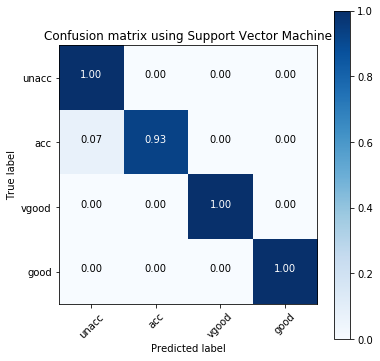

In [35]:
# Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(cars_new.cls.unique())
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using Support Vector Machine')

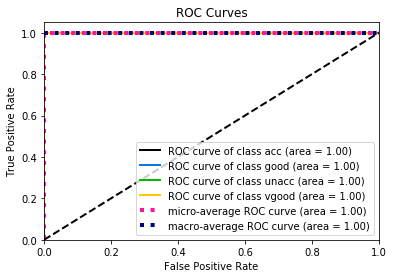

In [41]:
probas = model.predict_proba(X_test)
scikitplot.metrics.plot_roc(y_test, probas)